In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import math



In [2]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        # Larger kernels for better receptive field
        self.layer1 = nn.Conv2d(num_channels, 128, kernel_size=11, padding=5, stride=1)  # Big kernel for initial feature extraction
        self.layer2 = nn.Conv2d(128, 128, kernel_size=9, padding=4, stride=1)           # Still big
        self.layer3 = nn.Conv2d(128, 64, kernel_size=7, padding=3, stride=1)            # Slightly smaller
        self.layer4 = nn.Conv2d(64, 64, kernel_size=5, padding=2, stride=1)
        self.layer5 = nn.Conv2d(64, num_channels, kernel_size=5, padding=2, stride=1)   # Output layer
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.layer5(x)
        return x

In [3]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))
        self.transform = transform
    
    def __len__(self):
        return len(self.lr_images)
    
    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_path = os.path.join(self.hr_dir, self.hr_images[idx])
        
        lr_img = Image.open(lr_path).convert("YCbCr").split()[0]
        hr_img = Image.open(hr_path).convert("YCbCr").split()[0]
        
        if self.transform:
            lr_img = self.transform(lr_img)
            hr_img = self.transform(hr_img)
        
        return lr_img, hr_img


In [4]:
def calculate_psnr(pred, target):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return 100.0
    return 20 * math.log10(1.0 / math.sqrt(mse.item()))


In [5]:
def validate(model, val_loader, criterion, device):
    """
    This runs AFTER each training epoch
    Calculates validation loss and PSNR
    """
    model.eval()  # Set to evaluation mode
    val_loss = 0.0
    val_psnr = 0.0
    
    with torch.no_grad():  # No gradient calculation
        for lr, hr in val_loader:
            lr, hr = lr.to(device), hr.to(device)
            output = model(lr)
            loss = criterion(output, hr)
            
            val_loss += loss.item()
            val_psnr += calculate_psnr(output, hr)
    
    avg_val_loss = val_loss / len(val_loader)
    avg_val_psnr = val_psnr / len(val_loader)
    
    return avg_val_loss, avg_val_psnr

In [ ]:
BATCH_SIZE =           
LEARNING_RATE = 1e-4     
NUM_EPOCHS = 10         
WEIGHT_DECAY = 1e-5     


In [7]:
# -----------------------
# 5. Data Preparation
# -----------------------
transform = transforms.Compose([
    transforms.ToTensor()
])


In [8]:
# Training data
train_dataset = SRDataset("/home/akanksh/Akshu/ML/project/dataset/train/low_res", "/home/akanksh/Akshu/ML/project/dataset/train/high_res", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Validation data
val_dataset = SRDataset("/home/akanksh/Akshu/ML/project/dataset/val/low_res", "/home/akanksh/Akshu/ML/project/dataset/val/high_res", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

print(f"\nUsing device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")


Using device: cuda
Model parameters: 1848385



TRAINING STARTED
Epoch [1/10]
  Train -> Loss: 0.011646 | PSNR: 21.96 dB | Acc: 0.9625 | Prec: 0.9615
  Val   -> Loss: 0.002375 | PSNR: 26.44 dB | Acc: 0.9602 | Prec: 0.9584
  ✅ Best model saved! (Val PSNR: 26.44 dB)

Epoch [2/10]
  Train -> Loss: 0.001820 | PSNR: 27.72 dB | Acc: 0.9724 | Prec: 0.9636
  Val   -> Loss: 0.001411 | PSNR: 28.74 dB | Acc: 0.9706 | Prec: 0.9603
  ✅ Best model saved! (Val PSNR: 28.74 dB)

Epoch [3/10]
  Train -> Loss: 0.001277 | PSNR: 29.20 dB | Acc: 0.9752 | Prec: 0.9711
  Val   -> Loss: 0.001168 | PSNR: 29.58 dB | Acc: 0.9735 | Prec: 0.9681
  ✅ Best model saved! (Val PSNR: 29.58 dB)

Epoch [4/10]
  Train -> Loss: 0.001133 | PSNR: 29.76 dB | Acc: 0.9758 | Prec: 0.9750
  Val   -> Loss: 0.001088 | PSNR: 29.90 dB | Acc: 0.9741 | Prec: 0.9722
  ✅ Best model saved! (Val PSNR: 29.90 dB)

Epoch [5/10]
  Train -> Loss: 0.001102 | PSNR: 29.85 dB | Acc: 0.9765 | Prec: 0.9751
  Val   -> Loss: 0.001043 | PSNR: 30.09 dB | Acc: 0.9748 | Prec: 0.9723
  ✅ Best model saved!

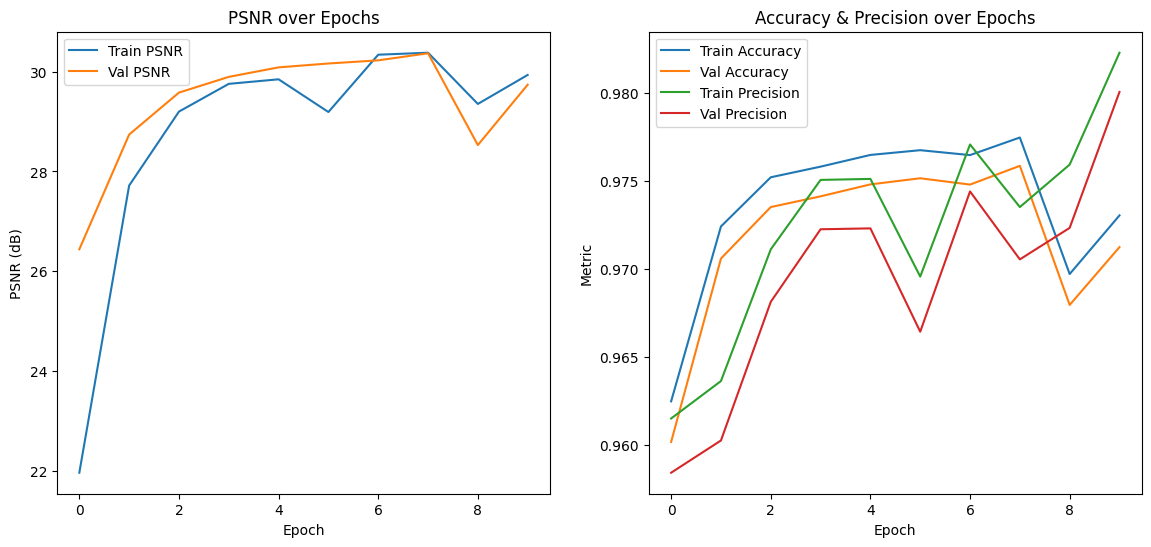

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score
import numpy as np

print("\n" + "="*60)
print("TRAINING STARTED")
print("="*60)

best_val_psnr = 0.0

train_psnrs_list = []
val_psnrs_list = []
train_accuracies_list = []
val_accuracies_list = []
train_precisions_list = []
val_precisions_list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_psnr = 0.0
    
    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)
        
        optimizer.zero_grad()
        output = model(lr)
        loss = criterion(output, hr)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_psnr += calculate_psnr(output, hr)
    
    avg_train_loss = train_loss / len(train_loader)
    avg_train_psnr = train_psnr / len(train_loader)
    
    avg_val_loss, avg_val_psnr = validate(model, val_loader, criterion, device)
    
    train_preds_flat = []
    train_labels_flat = []
    val_preds_flat = []
    val_labels_flat = []
    threshold = 0.5  # For binary metrics
    
    # Training data
    model.eval()
    with torch.no_grad():
        for lr, hr in train_loader:
            lr, hr = lr.to(device), hr.to(device)
            output = model(lr)
            train_preds_flat.append(output.cpu().numpy().flatten())
            train_labels_flat.append(hr.cpu().numpy().flatten())
    
    train_preds_flat = np.concatenate(train_preds_flat)
    train_labels_flat = np.concatenate(train_labels_flat)
    train_bin_preds = (train_preds_flat > threshold).astype(int)
    train_bin_labels = (train_labels_flat > threshold).astype(int)
    
    train_acc = accuracy_score(train_bin_labels, train_bin_preds)
    train_prec = precision_score(train_bin_labels, train_bin_preds, zero_division=0)
    
    # Validation data
    with torch.no_grad():
        for lr, hr in val_loader:
            lr, hr = lr.to(device), hr.to(device)
            output = model(lr)
            val_preds_flat.append(output.cpu().numpy().flatten())
            val_labels_flat.append(hr.cpu().numpy().flatten())
    
    val_preds_flat = np.concatenate(val_preds_flat)
    val_labels_flat = np.concatenate(val_labels_flat)
    val_bin_preds = (val_preds_flat > threshold).astype(int)
    val_bin_labels = (val_labels_flat > threshold).astype(int)
    
    val_acc = accuracy_score(val_bin_labels, val_bin_preds)
    val_prec = precision_score(val_bin_labels, val_bin_preds, zero_division=0)
    
    train_psnrs_list.append(avg_train_psnr)
    val_psnrs_list.append(avg_val_psnr)
    train_accuracies_list.append(train_acc)
    val_accuracies_list.append(val_acc)
    train_precisions_list.append(train_prec)
    val_precisions_list.append(val_prec)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train -> Loss: {avg_train_loss:.6f} | PSNR: {avg_train_psnr:.2f} dB | Acc: {train_acc:.4f} | Prec: {train_prec:.4f}")
    print(f"  Val   -> Loss: {avg_val_loss:.6f} | PSNR: {avg_val_psnr:.2f} dB | Acc: {val_acc:.4f} | Prec: {val_prec:.4f}")
    
    if avg_val_psnr > best_val_psnr:
        best_val_psnr = avg_val_psnr
        torch.save(model.state_dict(), "best_model.pth")
        print(f"   Best model saved! (Val PSNR: {avg_val_psnr:.2f} dB)")
    print()

# ========== PLOTTING METRICS ==========
plt.figure(figsize=(14,6))

# PSNR Plot
plt.subplot(1,2,1)
plt.plot(train_psnrs_list, label='Train PSNR')
plt.plot(val_psnrs_list, label='Val PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Epochs')
plt.legend()

# Accuracy & Precision Plot
plt.subplot(1,2,2)
plt.plot(train_accuracies_list, label='Train Accuracy')
plt.plot(val_accuracies_list, label='Val Accuracy')
plt.plot(train_precisions_list, label='Train Precision')
plt.plot(val_precisions_list, label='Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Accuracy & Precision over Epochs')
plt.legend()

plt.show()


In [11]:
def inference(model_class, model_path, input_dir, output_dir, device):
    # Load the model
    model = model_class().to(device)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    os.makedirs(output_dir, exist_ok=True)

    # Define preprocessing transform
    transform = transforms.ToTensor()

    # Process images
    image_files = sorted([
        f for f in os.listdir(input_dir)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])

    print(f"Processing {len(image_files)} images...\n")

    with torch.no_grad():
        for img_name in image_files:
            lr_img = Image.open(os.path.join(input_dir, img_name)).convert("YCbCr")
            y, cb, cr = lr_img.split()

            y_tensor = transform(y).unsqueeze(0).to(device)
            sr_y = model(y_tensor).clamp(0.0, 1.0)
            sr_y_img = transforms.ToPILImage()(sr_y.squeeze(0).cpu())

            cb = cb.resize(sr_y_img.size, Image.BICUBIC)
            cr = cr.resize(sr_y_img.size, Image.BICUBIC)
            sr_img = Image.merge("YCbCr", [sr_y_img, cb, cr]).convert("RGB")

            sr_img.save(os.path.join(output_dir, f"SR_{img_name}"))
            print(f" Saved: SR_{img_name}")
#
    # print(f"\n All {len(image_files)} images processed

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inference(
    model_class=SRCNN,                     # your SRCNN class
    model_path="/home/akanksh/Akshu/ML/project/best_model.pth",           # path to saved model
    input_dir="/home/akanksh/Akshu/ML/project/dataset/raw",      # LR images
    output_dir="/home/akanksh/Akshu/ML/project/dataset/out",  # SR outputs
    device=device
)


Processing 4 images...

 Saved: SR_Pasted image (2).png
 Saved: SR_Pasted image (3).png
 Saved: SR_Pasted image (4).png
 Saved: SR_Pasted image.png
